In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
T18 = pd.read_csv('/restricted/projectnb/ma679/ProcessedData/cxxiong/T18_new.csv')
M18 = pd.read_csv('/restricted/projectnb/ma679/ProcessedData/cxxiong/M18_new.csv')
T19 = pd.read_csv('/restricted/projectnb/ma679/ProcessedData/cxxiong/T19_new.csv')
M19 = pd.read_csv('/restricted/projectnb/ma679/ProcessedData/cxxiong/M19_new.csv')
T20 = pd.read_csv('/restricted/projectnb/ma679/ProcessedData/cxxiong/T20_new.csv')
M20 = pd.read_csv('/restricted/projectnb/ma679/ProcessedData/cxxiong/M20_new.csv')

In [458]:
M_train = pd.concat([M18, M19], ignore_index=True) 
T_train = pd.concat([T18, T19], ignore_index=True)
total_M = pd.concat([M18,M19,M20],ignore_index=True)
total_T = pd.concat([T18,T19,T20],ignore_index=True)
M_train_feature = M_train.drop(columns=['readmit_flag','PL_NCHS'])
M_train_label = M_train[['readmit_flag']]
M_test_feature = M20.drop(columns=['readmit_flag','PL_NCHS'])
M_test_label = M20[['readmit_flag']]
T_train_feature = T_train.drop(columns=['readmit_flag'])
T_train_label = T_train[['readmit_flag']]
T_test_feature = T20.drop(columns=['readmit_flag'])
T_test_label = T20[['readmit_flag']]
# # random_state = 20
# X_train, X_val, y_train, y_val = train_test_split(MX, MY, test_size=0.25, random_state=random_state)

train_features = np.array(M_train_feature)
train_label = np.array(M_train_label)
val_features = np.array(M_test_feature)
val_label = np.array(M_test_label)
# x_test_features = np.array(M_test.drop(columns=['READMISSION']))
# y_test_features = M_test[['READMISSION']]
# x_test_features = np.array(test_df)

In [459]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest, chi2
skb = SelectKBest(chi2, k=40)
train_features = skb.fit_transform(train_features, train_label)
val_features = skb.transform(val_features)


In [460]:
print(train_features.shape)
print(val_features.shape)

(20975, 40)
(8811, 40)


In [461]:
# Maybe useful
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)

In [462]:
# from imblearn.under_sampling import RandomUnderSampler
# rus=RandomUnderSampler(sampling_strategy={0:700,1:371})
# X_resampled, y_resampled = rus.fit_resample(train_features, train_label)
# train_features = X_resampled
# train_label = y_resampled

In [463]:
neg, pos = np.bincount(total_T['readmit_flag'])
total = neg + pos
print(neg,pos,total)

157712 531 158243


In [464]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(128, activation='relu',     
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dense(128, activation='relu'),   
      keras.layers.Dropout(0.7),
      keras.layers.Dense(32, activation='relu'),   
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

# def make_model(metrics=METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.Input(shape=train_features.shape[1:]),
# #       keras.layers.Input(shape = (train_features.shape[-1],)),
#       keras.layers.Dense(32, activation='relu'),
#       keras.layers.Dense(32, activation='relu'),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(32, activation='relu'),     
# #           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dense(32, activation='relu'),
# #       keras.layers.Dropout(0.5),
# #       keras.layers.Dense(64, activation='relu'),     
# # #           input_shape=(train_features.shape[-1],)),
# #       keras.layers.Dense(64, activation='relu'),   
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(learning_rate=1e-2),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)
  model.compile(
      optimizer=keras.optimizers.SGD(learning_rate=1e-2),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
    
    
  return model

In [465]:
# Baseline model

EPOCHS = 100
BATCH_SIZE = 2048 #Large batch size to make sure each batch 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True,
    start_from_epoch = 30)

In [466]:
model = make_model()
model.summary()

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_531 (Dense)           (None, 128)               5248      
                                                                 
 dense_532 (Dense)           (None, 128)               16512     
                                                                 
 dropout_246 (Dropout)       (None, 128)               0         
                                                                 
 dense_533 (Dense)           (None, 32)                4128      
                                                                 
 dropout_247 (Dropout)       (None, 32)                0         
                                                                 
 dense_534 (Dense)           (None, 1)                 33        
                                                                 
Total params: 25921 (101.25 KB)
Trainable params: 25

In [467]:
# model without initial bias
model.predict(train_features)

656/656 [==============================] - 1s 942us/step


array([[0.14915536],
       [0.19093941],
       [0.17352635],
       ...,
       [0.25409752],
       [0.10653386],
       [0.16536315]], dtype=float32)

In [468]:
# evaluation model without initial bias
results = model.evaluate(train_features, train_label, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2927


In [469]:
#set an initial bias 
initial_bias = np.log([pos/neg])
initial_bias

array([-5.69376384])

In [470]:
#model with output bias
model = make_model(output_bias = initial_bias)
model.predict(train_features)

656/656 [==============================] - 1s 1ms/step


array([[0.0019833 ],
       [0.00375377],
       [0.00507759],
       ...,
       [0.00380431],
       [0.00427726],
       [0.00387201]], dtype=float32)

In [471]:
# evaluation with initial bias, should have a lower loss
results = model.evaluate(train_features, train_label, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2125


In [472]:
# set check-point for initial weight
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [473]:
# If the biased model has the BETTER RESULT, train the biased model with 20 epoches.
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_label,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_label), 
    verbose=0)

In [474]:
# Train the unbiased model for 20 epoches as a control group
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_label,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_label), 
    verbose=2)

Epoch 1/20
11/11 - 1s - loss: 0.2071 - tp: 0.0000e+00 - fp: 7.0000 - tn: 28686.0000 - fn: 1093.0000 - accuracy: 0.9631 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4992 - prc: 0.0368 - val_loss: 0.1959 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8501.0000 - val_fn: 310.0000 - val_accuracy: 0.9648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4831 - val_prc: 0.0327 - 1s/epoch - 104ms/step
Epoch 2/20
11/11 - 0s - loss: 0.2061 - tp: 0.0000e+00 - fp: 4.0000 - tn: 20188.0000 - fn: 783.0000 - accuracy: 0.9625 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5071 - prc: 0.0373 - val_loss: 0.1950 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8501.0000 - val_fn: 310.0000 - val_accuracy: 0.9648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4843 - val_prc: 0.0329 - 113ms/epoch - 10ms/step
Epoch 3/20
11/11 - 0s - loss: 0.2067 - tp: 0.0000e+00 - fp: 6.0000 - tn: 20186.0000 - fn: 783.0000 - accuracy: 0.9624 - precision: 0.0000e+00 -

In [475]:
#Baseline model
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(val_features, batch_size=BATCH_SIZE)

5/5 [==============================] - 0s 2ms/step


In [476]:
baseline_results = model.evaluate(val_features, val_label,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.1812780797481537
tp :  0.0
fp :  0.0
tn :  8501.0
fn :  310.0
accuracy :  0.964816689491272
precision :  0.0
recall :  0.0
auc :  0.49435532093048096
prc :  0.03320582956075668



In [477]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

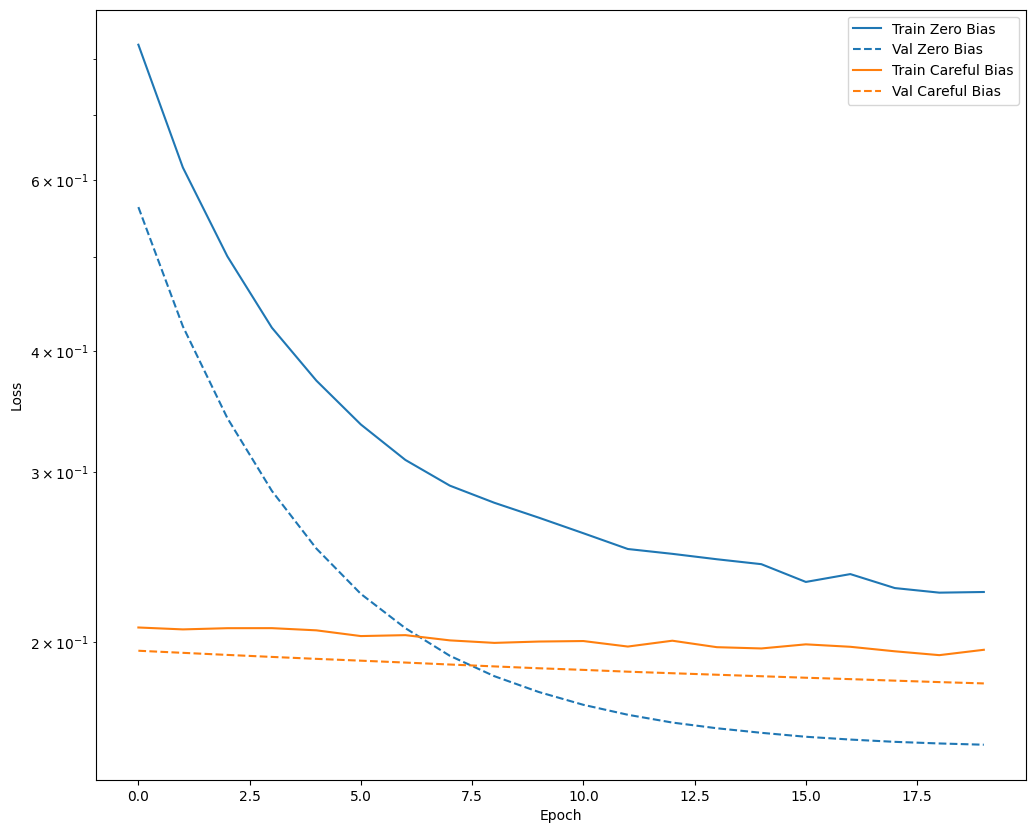

In [478]:
# plot loss
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()
    
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [479]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_label,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_label))

Epoch 1/100
11/11 [==============================] - 1s 44ms/step - loss: 0.2081 - tp: 0.0000e+00 - fp: 4.0000 - tn: 28689.0000 - fn: 1093.0000 - accuracy: 0.9632 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4842 - prc: 0.0342 - val_loss: 0.1959 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8501.0000 - val_fn: 310.0000 - val_accuracy: 0.9648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4833 - val_prc: 0.0327
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2077 - tp: 0.0000e+00 - fp: 1.0000 - tn: 20191.0000 - fn: 783.0000 - accuracy: 0.9626 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4873 - prc: 0.0351 - val_loss: 0.1950 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 8501.0000 - val_fn: 310.0000 - val_accuracy: 0.9648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4844 - val_prc: 0.0329
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2068 - tp: 0.0000e+00 - fp: 6

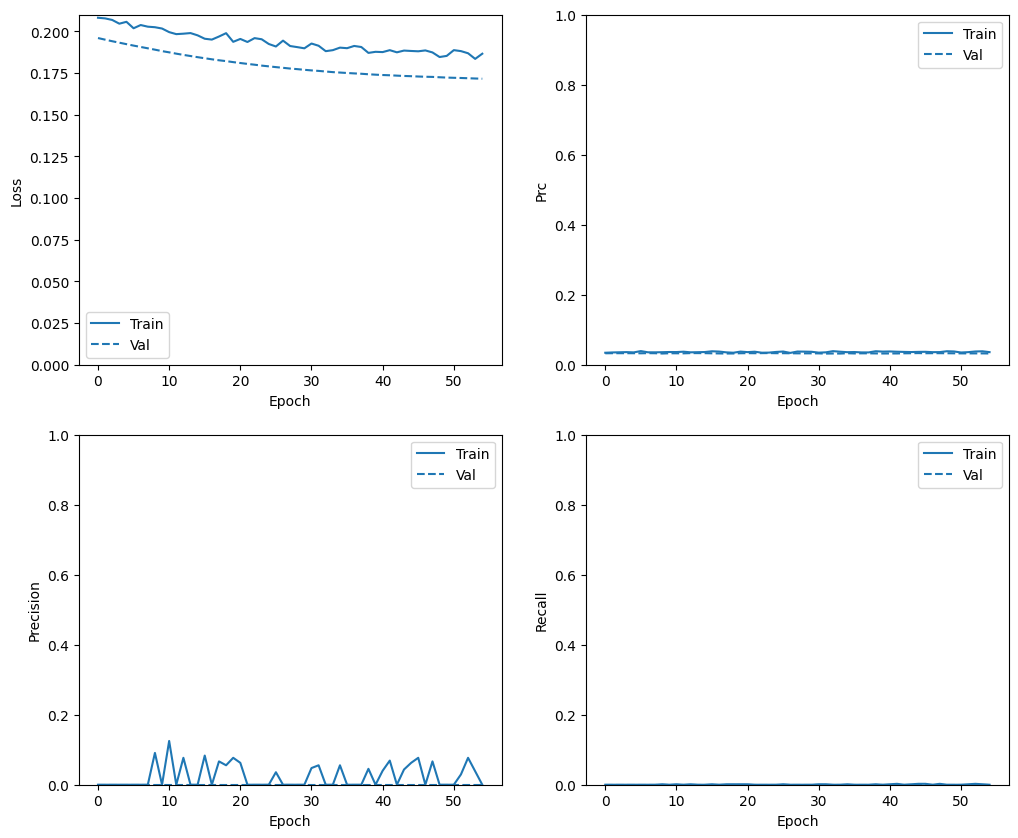

In [480]:
# plot 'loss', 'prc', 'precision', 'recall'
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(baseline_history)

In [515]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [482]:
# def plot_prc(name, labels, predictions, **kwargs):
#     precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

#     plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
#     plt.xlabel('Precision')
#     plt.ylabel('Recall')
#     plt.grid(True)
#     ax = plt.gca()
#     ax.set_aspect('equal')
    
# plot_prc("Train Baseline", y_train_features, train_predictions_baseline, color=colors[0])
# plot_prc("Test Baseline", y_test_features, test_predictions_baseline, color=colors[0], linestyle='--')
# plt.legend(loc='lower right');

In [509]:
# adjust the class weight
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total) * 10
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 10.03
Weight for class 1: 149.00


In [510]:
#Train model with weighted class
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_label,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_label),
    # The class weights go here
    class_weight=class_weight)


Epoch 1/100
11/11 [==============================] - 1s 45ms/step - loss: 20.1300 - tp: 278.0000 - fp: 6297.0000 - tn: 22396.0000 - fn: 815.0000 - accuracy: 0.7612 - precision: 0.0423 - recall: 0.2543 - auc: 0.5020 - prc: 0.0376 - val_loss: 0.1935 - val_tp: 0.0000e+00 - val_fp: 4.0000 - val_tn: 8497.0000 - val_fn: 310.0000 - val_accuracy: 0.9644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4939 - val_prc: 0.0336
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 14.9580 - tp: 149.0000 - fp: 3509.0000 - tn: 16683.0000 - fn: 634.0000 - accuracy: 0.8025 - precision: 0.0407 - recall: 0.1903 - auc: 0.5205 - prc: 0.0392 - val_loss: 0.2088 - val_tp: 0.0000e+00 - val_fp: 6.0000 - val_tn: 8495.0000 - val_fn: 310.0000 - val_accuracy: 0.9641 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5245 - val_prc: 0.0378
Epoch 3/100
11/11 [==============================] - 0s 12ms/step - loss: 14.6028 - tp: 143.0000 - fp: 3567.0000 - tn: 16625.0

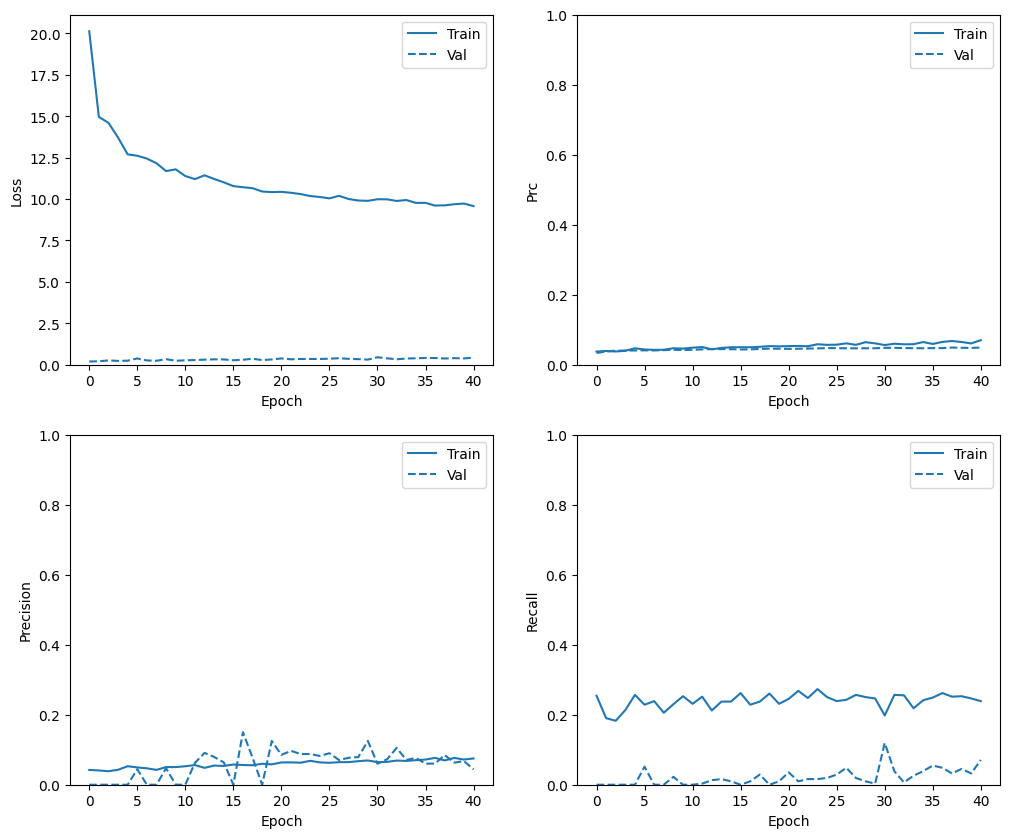

In [511]:
#Training history
plot_metrics(weighted_history)

In [512]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(val_features, batch_size=BATCH_SIZE)

5/5 [==============================] - 0s 2ms/step


In [513]:
weighted_results = weighted_model.evaluate(val_features, val_label,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

loss :  0.4496740996837616
tp :  37.0
fp :  581.0
tn :  7920.0
fn :  273.0
accuracy :  0.9030756950378418
precision :  0.05987054854631424
recall :  0.11935483664274216
auc :  0.5818915367126465
prc :  0.04824400693178177

